In [682]:
# Initialize Otter
import otter
grader = otter.Notebook("cw1.ipynb")

In [683]:
import itertools
from collections import defaultdict, Counter
from typing import List, Tuple, Dict, Self, Any, Callable
from abc import ABC
import math

# test

# Part A: CSP

This part of the assignment will ask you to construct a set of cards for Dobble using CSP algorithms. Dobble is a card game with 55 cards, each printed with 8 symbols. In each round of Dobble, each player is handed a card face up with a pile of cards in the middle facing down. When the top card in the middle pile is flipped, players must race to call out the symbol on the middle card that matches a symbol in their hand. 

The game works because the cards have the special property that each pair of cards share exactly one symbol between them. Some fancy maths tells us that given $n$ symbols per card, a Dobble deck will require exactly $k = n^2 - n + 1$ cards and symbols.  

<!-- BEGIN QUESTION -->

### **Question 1.** 
Complete the following class methods for the ```Card``` and ```Deck``` classes. The methods you are expected to complete are ```Card.__eq__```, ```Deck.__eq__```, ```Deck.from_all_combinations```, ```Deck.is_valid```.

In [684]:
def generate_symbols(num_symbols: int) -> List[str]:
    return [f"Symbol_{i}" for i in range(n)]

class Card:
    def __init__(self, symbols: List[str]):
        self.symbols = set(symbols)
    
    def __hash__(self):
        """
        Hash function that is compatible with card equality.
        """
        sorted_symbols = tuple(sorted(self.symbols))
        return hash(sorted_symbols)
    
    def __eq__(self, other: Self) -> bool:
        """
        Check if two cards are the same.
        """
        # ...
        return self.symbols == other.symbols 

In [685]:
class Deck:
    def __init__(self, cards: List[Card] = []):
        self.cards: List[Card] = cards 
    
    def __eq__(self, other: Self) -> bool:
        """Equality test: two Decks are equal if one is a permutation of the other.
        
        Creates a dictionary of counts for each type of card (in the format Counter(cards) = {Card(['x', 'y', 'z']): 
        1, Card(['a', 'b', 'c']): ..})
        """
        # ...
        return Counter(self.cards) == Counter(other.cards)

    def from_all_configurations(symbols, symbols_per_card) -> Self:
        """
        Return a deck containing all possible dobble cards from a set of symbols. This is not a valid dobble set.
        
        Creates an empty array of cards. For each combination of symbols with length symbols_per_card, adds the 
        combination to the list. Returns a deck with the list of cards.  
        """
        # ...
        cards = []
        
        for combination in itertools.combinations(symbols, symbols_per_card):
            card = Card(combination)
            cards.append(card)
        return Deck(cards)
    
    def is_valid(self) -> bool:
        """
        Check if the deck is a valid dobble deck.
        
        For each card in the deck, enumerate to assign an integer value index to it (to prevent from returning False
         when a card is checked against itself. 
         
         The rules for a valid set of dobble cards are:
            1. Each card has the same number of symbols.
            2. Each pair of cards has exactly one symbol in common.
            3. There are no duplicate cards.
            
        Here we check rule 2 and 3. Rule 1 cannot be broken as in the previous question we generated all the 
        combinations from the set number given. 
        """
        # ...
        for i, card in enumerate(self.cards):
            for j, other_card in enumerate(self.cards):
                if i == j:
                    continue
                if card == other_card or len(card.symbols.intersection(other_card.symbols)) != 1:
                    return False
        return True
    

    def __iter__(self):
        """Allow iteration through a deck"""
        return iter(self.cards)

In [686]:
grader.check("qA.1")

qA.1 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### **Question 2.** 
Complete the ```satisfied``` method for ```SharedSymbolConstraint``` and ```SharingNSymbolsConstraint```.

In [687]:
class Constraint(ABC):
    # This is an abstract class, nothing to implement here.
    def __init__(self, cards: Tuple[str, str]):
        self.cards = cards

    def satisfied(self, assignment: Dict[str, Card]) -> bool:
        raise NotImplementedError
    
class SharedSymbolConstraint(Constraint):
    """
    This constraint checks to see if two cards share exactly one symbol.
    """
    def __init__(self, cards):
        super(SharedSymbolConstraint, self).__init__(cards)
    
    def satisfied(self, assignment: Dict[str, Card]) -> bool:
        """
        Check if the constraint is satisfied based on the current variable assignment.
    
        Verifies if the two cards assigned to the constraint share exactly one symbol. 
        Checks the following conditions:
            1. If either cardID is not present in the assignment, the constraint is considered satisfied (returning True).
            2. If both cards are present in the assignment, it ensures:
            - The two cards are not identical.
            - The two cards share exactly one symbol in common.
            
        If both cards share one symbol in common and are distinct, the constraint is satisfied and the function returns True. 
        Otherwise, it returns False.
        
        
        
        """
        #...
        id1, id2 = self.cards # a tuple of 2 str containing the variable ID for the cards
        
        if id1 not in assignment or id2 not in assignment: # check if the cards are already in the assignment
            return True # if they are, there are no constraints to check
        
        card1, card2 = assignment[id1], assignment[id2] # if they have been assigned to cards, get the cards
        
        if card1 == card2 or len(card1.symbols.intersection(card2.symbols)) != 1: 
            return False
        else:
            return True

class SharingNSymbolsConstraint(Constraint):
    """
    This constraint checks to see if two cards share exactly N symbols.
    """
    def __init__(self, cards, N:int):
        super(SharingNSymbolsConstraint, self).__init__(cards)
        self.N = N

    def satisfied(self, assignment: Dict[str, Card]) -> bool:
        """
        The same as the previous class, but instead of only for 1 shared symbol, checks for N shared symbols.
        """
        #...
        id1, id2 = self.cards
        
        card1, card2 = assignment[id1], assignment[id2]
        
        if card1 == card2:
            return False
        elif len(card1.symbols.intersection(card2.symbols)) != self.N:
            return False
        else:
            return True

In [688]:
grader.check("qA.2")

qA.2 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### **Question 3.** 
The CSP class is defined by a list of variable names, a dictionary of domains for each variable, and a list of constraints. Complete the ```consistent``` and ```backtrack``` methods for ```CSP```.

In [689]:
class CSP:
    """
    A class representing a Constraint Satisfaction Problem.
    """
    def __init__(self, variables: List[str], domains: Dict[str, List[Card]], constraints: List[Constraint]):
        self.variables: List[str] = variables
        self.domains: Dict[str, Any] = domains

        # Store constraints in a dict for easier lookup during search
        self.constraints = defaultdict(list)
        for constraint in constraints:
            variable1, variable2 = constraint.cards
            self.constraints[variable1].append(constraint)
            self.constraints[variable2].append(constraint) 
            
    def consistent(self, variable: str, assignment: Dict[str, Card]) -> bool:
        """Return true if the assignment of variable is consistent with the constraints"""
        # ...
        
        for constraint in self.constraints[variable]:
            if not constraint.satisfied(assignment):
                return False
        return True

    def backtrack(self, assignment: Dict[str, Card]) -> Dict[str, Card]:
        """Recursive function that performs assigns a value to the next unassigned card """
        if len(assignment) == len(self.variables): # Return if all variables have been assigned
            return assignment

        # Set 'first' to be the first unassigned variable
        first = [var for var in self.variables if var not in assignment][0]
        
        for value in self.domains[first]:
            local_assignment = assignment.copy()
            local_assignment[first] = value
            if self.consistent(first, local_assignment):
                result = self.backtrack(local_assignment)
                if result is not None:
                    return result

    def solve(self):
        return self.backtrack({})

In [690]:
grader.check("qA.3")

qA.3 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### **Question 4.** 
Define the set of constraints and run the CSP search to produce a result.

In [691]:
def generate_symbols(num_symbols: int) -> List[str]:
    return [f"Symbol_{i}" for i in range(num_symbols)]

s = 4  # Symbols per card
k = int(s*(s+1)/2)  # The total number of unique symbols
n = s+1 # number of cards


In [692]:
# Define the variables and domains.
variables = ['card1', 'card2', 'card3', 'card4', 'card5']
domains = {var: [Card(symbols) for symbols in itertools.combinations(generate_symbols(k), s)] for var in variables}
...


Ellipsis

In [693]:
# Define the list of constraints between all the cards.

constraints = [SharedSymbolConstraint(('card1', 'card2')), SharedSymbolConstraint(('card1', 'card3')), 
               SharedSymbolConstraint(('card1', 'card4')), SharedSymbolConstraint(('card1', 'card5')), 
               SharedSymbolConstraint(('card2', 'card3')), SharedSymbolConstraint(('card2', 'card4')), 
               SharedSymbolConstraint(('card2', 'card5')), SharedSymbolConstraint(('card3', 'card4')), 
               SharedSymbolConstraint(('card3', 'card5')), SharedSymbolConstraint(('card4', 'card5'))] 
...

# fix this!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Ellipsis

In [694]:
csp = CSP(variables, domains, constraints)
solution = csp.solve()


In [695]:
csp.domains

{'card1': [<__main__.Card at 0x420cf2650>,
 'card2': [<__main__.Card at 0x122726e10>,
 'card3': [<__main__.Card at 0x124deef10>,
 'card4': [<__main__.Card at 0x14525f890>,
 'card5': [<__main__.Card at 0x143cddf50>,
  <__main__.Card at 0x1231e0f10>]}

In [696]:
grader.check("qA.4")

qA.4 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### **Question 5.** 
Produce a set of plots that show how the time taken to find a solution varies against $n$ the number of symbols per card, $k$ the number of cards in the deck, $s$ number of available symbols and $m$ the number of symbols shared between cards. Don't make your numbers too large since it will take a long time to run. Analyse and discuss your plots.

In [697]:
import timeout_decorator

# Define the function to create and solve the CSP problem allowing variables to be varied

@timeout_decorator.timeout(60) # This will make sure one search run does not run for more than 60 seconds. You can change this number as needed.
def run_csp(n_symbols: int, n_cards: int, symbols_per_card: int, n_shared_symbols: int):
    s = symbols_per_card # Symbols per card
    k = n_symbols # The total number of unique symbols
    n = n_cards # number of cards
    
    # Define the variables and domains.
    vars = [f'card{i}' for i in range(n_cards)]
    domains = {var: [Card(symbols) for symbols in itertools.combinations(generate_symbols(k), s)] for var in variables}
    
    # Define the list of constraints between all the cards.
    cons = []
    
    for i, card in enumerate(vars):
        for j, other_card in enumerate(vars):
            if i == j:
                continue
            else: 
                cons.append(SharingNSymbolsConstraint((card, other_card), n_shared_symbols))
                
    csp = CSP(variables, domains, constraints)
    solution = csp.solve()
    
    return solution

In [ ]:
from matplotlib import pyplot as plt
import timeit # This will allow you to calculate runtimes, see https://docs.python.org/3/library/timeit.html for more info

# Make your plots here
times = []

x_min = 1
x_max = 8

for i in range(x_min, x_max):
    n_symbols = int(i*(i+1)/2)
    n_cards = i+1
    n_shared_symbols = 1
    
    time_taken = timeit.timeit(lambda: run_csp(n_symbols, n_cards, i, n_shared_symbols), number=1)
    times.append(time_taken)
    
plt.plot(times)
plt.xlabel("Symbols per card")
plt.ylabel("Time taken to solve CSP (seconds)")

plt.xlim(x_min, x_max)
plt.ylim(0, 8)
plt.title("Time taken to solve CSP against symbols per card")
plt.show()

_Discuss your results here... What are the main patterns you notice? Why do the plots look the way they do? What impact do the parameters have on the runtime of the search algorithm?_

<!-- END QUESTION -->

# Part B: A* Search

In this part of the assignment you will be working on some animation! Given two polyons (sets of points in discrete 2D space connected by a line), your task is to create a 'smooth' transition from the first to the second. In order to make the transition, you are only allowed to move a single point at a time to an adjacent point either up or down. In order to find the fewest possible steps to go from the starting polygon to the goal, you will be implementing A* search.

In [666]:
import itertools
from typing import List, Tuple, Dict, Self, Any, Callable
from abc import ABC
import heapq
from collections import OrderedDict
from typing import List, Tuple, Set, Union, Self
import numpy as np


In [667]:
GRID_SIZE = 4 # Defines an 8x8 grid

<!-- BEGIN QUESTION -->

### **Question 1.** 
Complete the following class methods for the ```Polygon``` class. The methods you are expected to complete are ```__hash__``` and ```generate_neighbours```.

In [668]:
class Point:
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def as_array(self):
        return np.array([self.x, self.y])

    def __hash__(self):
        return hash((self.x, self.y))

    def __eq__(self, other):
        return (self.x, self.y) == (other.x, other.y)
    
    def __lt__(self, other):
        return (self.x, self.y) < (other.x, other.y)

    def __repr__(self):
        return f"Point({self.x}, {self.y})"

In [669]:
class Polygon:
    def __init__(self, coordinates: Union[List[Tuple[int, int]], List[Point]]):
        """Instantiate a polygon from a list of points."""
        if not coordinates:
            raise ValueError("Polygon requires at least one coordinate.")
        if type(coordinates[0]) == tuple:
            coordinates = [Point(point[0], point[1]) for point in coordinates]
        unique_coords = list(OrderedDict.fromkeys(coordinates))  # Preserve order and remove duplicates
        if len(unique_coords) != len(coordinates):
            raise ValueError("Polygon has repeated coordinates!")
        self.points = unique_coords

    def as_list(self) -> List[Point]:
        """Return the set of points."""
        return self.points
    
    def as_array(self) -> np.array:
        """Return a representation of the current polygon as a numpy array"""
        return np.array([[point.x, point.y] for point in self.points])

    def __hash__(self):
        """Returns a hash for the current polygon. Isomorphic polygons must produce equivalent hashes."""
        # ...
        self.points = sorted(self.points)
        return hash(tuple(self.points))

    def __eq__(self, other):
        """Equality test for polygons compatible with the hash function."""
        # ...
        return hash(self) == hash(other)
        
    def __lt__(self, other):
        """Allow polygons to be compared."""
        return self.points < other.points    

    def generate_neighbours(self) -> List['Polygon']:
        """Generates possible neighbours of the current polygon. Ensure that the x and y coordinates of all points are within ±GRID_SIZE"""
        # ...
        neighbours = []
        
        for idx, point in enumerate(self.points):
            directions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
            for i, j in directions:
                new_point = Point(point.x + i, point.y + j)
                
                new_points = self.points.copy()
                new_points[idx] = new_point
                
                if new_point in self.points:
                    continue
                
                if -GRID_SIZE <= new_point.x <= GRID_SIZE and GRID_SIZE >= new_point.y >= -GRID_SIZE:
                    poly = Polygon(new_points)
                    neighbours.append(poly)
        return neighbours

In [670]:
grader.check("qB.1")

qB.1 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### **Question 2.**
Implement the functions ```difference```, ```minimal```, and ```centroid``` to compute the distance between two polygons.

In [671]:
from scipy.spatial.distance import cdist

def difference(A: Polygon, B: Polygon) -> float:
    """Returns the number of points in 'a' or 'b' that are not in both polygons."""
    # ...
    return len(set(A.points) ^ set(B.points))

def minimal(A: Polygon, B: Polygon) -> float:
    """Returns the smallest non-zero Manhattan (L1) distance between the points of 'a' and 'b' respectively, multiplied by the number of points in the goal that are still unreached."""
    # ...
    distances = cdist(A.as_array(), B.as_array(), "cityblock").diagonal()
    distances = distances[distances > 0]
    
    min_dist = min(distances)
    
    return min_dist * len(distances)

def centroid(A: Polygon, B:Polygon) -> float:
    """"Returns the Euclidean distance between the centroids (mean of the points) of the two polygons."""
    ...
    a_mean = np.mean(A.as_array(), axis=0)
    b_mean = np.mean(B.as_array(), axis=0)
    
    dist = np.linalg.norm(a_mean - b_mean)
    
    return dist

In [672]:
grader.check("qB.2")

qB.2 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### **Question 3.** 
State which of the above metrics are admissable. If they are not admissable, find a pair of polygons that overestimate the actual cost. Otherwise, explain why the heuristic will never overestimate the cost. Give your answer in the format described by the type definition.

In [673]:
difference_is_admissable = ... # True or False
difference_counter_example: Tuple[Polygon, Polygon] | str = ... # Explanation if admissable, else tuple of 2 Polygons

minimal_is_admissable = ... # True or False
minimal_counter_example: Tuple[Polygon, Polygon] | str = ... # Explanation if admissable, else tuple of 2 Polygons

centroid_is_admissable = ... # True or False
centroid_counter_example: Tuple[Polygon, Polygon] | str = ... # Explanation if admissable, else tuple of 2 Polygons

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### **Question 4.**
Complete the implementation of the A* algorithm below. The progress bar is optional but is there to help give an indication of how long it will take before all search routes are exhausted.

In [674]:
from tqdm.notebook import tqdm
def a_star(start: Polygon, goal: Polygon, heuristic: Callable[[Polygon, Polygon], float]) -> List[Polygon]:
    if len(start.as_list()) != len(goal.as_list()):
        raise ValueError("Polygons must be of the same size.")

    # Priority queue: elements are tuples (f_score, polygon)
    open_set = [(heuristic(start, goal), start)]
    heapq.heapify(open_set)

    came_from: Dict[Polygon, Polygon] = {}  # Keeps a log of the parent node used to generate the polygon for reconstructing path
    g_score: Dict[Polygon, float] = {start: 0}
    f_score: Dict[Polygon, float] = {start: heuristic(start, goal)}
    
    # Create progress bar based on estimated max number of steps
    max_steps = cdist(start.as_array(), goal.as_array(), 'cityblock').max(axis=0).sum() 
    pbar = tqdm(desc='A* Progress', unit='step', total = max_steps)
    while open_set:
        current_f, current = heapq.heappop(open_set)
        # Update progress bar
        pbar.n = math.floor(current_f)
        pbar.refresh() 
        
        # Check if we have reached the goal
        if current == goal:
            path = [current] #Reconstruct path
            while current in came_from: # Backtrack
                current = came_from[current]
                path.append(current)
            pbar.close()
            return path[::-1] #Return path in reverse order
        
        
        for neighbour in current.generate_neighbours():
            
            #Increment score by one
            new_g_score = g_score[current] + 1
            
            if new_g_score < g_score.get(neighbour, float('inf')): #Assume infinite distance if neighbour has not been 
                # visited
                came_from[neighbour] = current
                g_score[neighbour] = new_g_score
                f_score[neighbour] = new_g_score + heuristic(neighbour, goal)
                heapq.heappush(open_set, (f_score[neighbour], neighbour))
    pbar.close()
    return []  # return an empty list if no path is found

In [675]:
grader.check("qB.4")

A* Progress:   0%|          | 0/4.0 [00:00<?, ?step/s]

qB.4 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### **Question 5.** 
Now, we want to create polygons that do not contain self-intersections. Complete the ```intersecting_lines``` and ```_detect_intersection``` methods. You may define helper methods as needed.

In [676]:
class NonIntersectingPolygon(Polygon):

    @staticmethod
    def intersecting_lines(l1: Tuple[Point, Point], l2: Tuple[Point, Point]) -> bool:
        """Checks whether two line segments (a, b) and (r, q) intersect."""
        ...

    def _detect_intersection(self) -> bool:
        """Checks whether the current polygon has any intersecting lines."""
        ...

    def __init__(self, coordinates: Union[List[Tuple[int, int]], List[Point]]):
        super(NonIntersectingPolygon, self).__init__(coordinates)
        if self._detect_intersection():
            raise ValueError("These points result in intersecting lines.")
    
    def generate_neighbours(self):
        polygons = super(NonIntersectingPolygon, self).generate_neighbours()
        non_intersecting_polygons = []
        for polygon in polygons:
            try:
                non_intersecting_polygons.append(NonIntersectingPolygon(polygon.points))
            except ValueError:
                continue
        return non_intersecting_polygons


In [677]:
grader.check("qB.5")

qB.5 results:
    qB.5 - 1 result:
        ❌ Test case failed
        Error at line 12 in test qB.5:
              assert NonIntersectingPolygon.intersecting_lines(line_1, line_2) == True
        AssertionError:

    qB.5 - 2 result:
        ✅ Test case passed

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### **Question 6.**
Using the helper functions below, create a set of animations. How does the choice of heuristic, NonIntersectingPolygon vs standard Polygon and the shapes of the polygons affect the search algorithm?

In [678]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.animation as animation

%matplotlib widget

def plot_polygon(ax, polygon, color='blue'):
    """Helper function to plot a single polygon on given axes."""
    # Creating the patches for each point in the polygon (assuming ordered points)
    for i in range(len(polygon)):
        next_point = polygon[(i + 1) % len(polygon)]
        xs, ys = zip(*[polygon[i], next_point])
        ax.plot(xs, ys, marker='o', color=color)

def animate_transformation(path: List[Polygon]):
    """Animates the transformation from start to goal polygon using the path provided."""
    fig, ax = plt.subplots()
    
    # Set limits and aspect
    ax.set_xlim(-GRID_SIZE, GRID_SIZE)
    ax.set_ylim(-GRID_SIZE, GRID_SIZE)
    ax.set_aspect('equal')
    
    
    # Artists to update in the animation
    artists = []

    def init():
        # Initialize the plot elements
        ax.clear()
        ax.set_xlim(-GRID_SIZE, GRID_SIZE)
        ax.set_ylim(-GRID_SIZE, GRID_SIZE)
        return artists

    def update(frame):
        # This function will be called for each frame of the animation
        ax.clear()
        ax.set_xlim(-GRID_SIZE, GRID_SIZE)
        ax.set_ylim(-GRID_SIZE, GRID_SIZE)
        polygon = path[frame]
        plot_polygon(ax, polygon.as_array(), color='blue')

        return artists
    
    ani = animation.FuncAnimation(fig, update, frames=len(path), init_func=init,
                                  blit=False, interval=500, repeat=True)

    # Display animation
    plt.show()
    return ani


A* Progress:   0%|          | 0/52.0 [00:00<?, ?step/s]

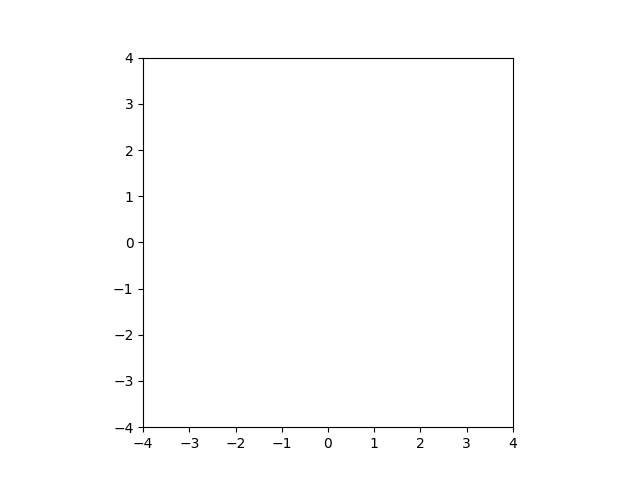

/Users/zoesztandke/Library/Mobile Documents/com~apple~CloudDocs/year 2/ra/cw1/venv/lib/python3.11/site-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [679]:
import timeit # To help you measure the runtime if you find it useful

# Example usage, this may take a little while to run [took about 10 minutes for me 💀]. Probably better to use smaller polygons

start_polygon = Polygon([(1, 1), (3, 0), (1, -1), (0, -3), (-1, -1), (-3, 0), (-1, 1), (0, 3)])
goal_polygon = Polygon([(1, 4), (2, 2), (2, 0), (1, -2), (-1, -2), (-2, 0), (-2, 2), (-1, 4)])

# A fancy heuristic to speed up the search
def fancy_heuristic(a, b):
    a = a.as_array()
    b = b.as_array()
    distance_matrix = cdist(a,b, 'cityblock')
    sum = 0
    for i in range(distance_matrix.shape[0]):
        j = distance_matrix[i].argmin()
        sum += distance_matrix[i, j]
        distance_matrix = np.delete(distance_matrix, j, axis=1)
    return sum

transformation_path = a_star(start_polygon, goal_polygon, fancy_heuristic)
ani = animate_transformation(transformation_path)


_Discuss your findings here..._

<!-- END QUESTION -->



---

To double-check your work, the cell below will rerun all of the autograder tests.

In [680]:
grader.check_all()

A* Progress:   0%|          | 0/4.0 [00:00<?, ?step/s]

qA.1 results: All test cases passed!

qA.2 results: All test cases passed!

qA.3 results: All test cases passed!

qA.4 results: All test cases passed!

qB.1 results: All test cases passed!

qB.2 results: All test cases passed!

qB.3 results: All test cases passed!

qB.4 results: All test cases passed!

qB.5 results:
    qB.5 - 1 result:
        ❌ Test case failed
        Error at line 12 in test qB.5:
              assert NonIntersectingPolygon.intersecting_lines(line_1, line_2) == True
        AssertionError:

    qB.5 - 2 result:
        ✅ Test case passed

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [681]:
# Save your notebook first, then run this cell to export your submission.
grader.export(run_tests=True)

/Users/zoesztandke/Library/Mobile Documents/com~apple~CloudDocs/year 2/ra/cw1/venv/lib/python3.11/site-packages/otter/check/notebook.py:493: UserWarning: Could not locate a PDF to include
  warnings.warn("Could not locate a PDF to include")
